In [68]:
import requests
import pandas as pd
import geopandas as gpd
import folium
import branca

## Map

In [69]:
# Define the URL and headers
url = "https://urban-heat.meteotest.io/api/1.0/stations"
headers = {
    "Accept": "text/csv"
}

# Make the GET request
response = requests.get(url, headers=headers)

# Check if the request was successful
if response.status_code == 200:
    # Read CSV content directly into pandas DataFrame
    test = pd.read_csv(io.StringIO(response.text))
else:
    print(f"Request failed with status code: {response.status_code}")

In [2]:
# Define the URL
url = "https://urban-heat.meteotest.io/api/1.0/stations"

# Make the GET request
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    # Read JSON content directly into pandas DataFrame
    stations = gpd.read_file(response.text)
else:
    print(f"Request failed with status code: {response.status_code}")

In [7]:
stations

,id,name,altitude,dateObserved,temperature,relativeHumidity,geometry
0,12E350FEFF6E959E,Eymattstrasse-Bern,542,2023-09-08 12:10:02+00:00,30.506218,41.350650,POINT (46.95149 7.39239)
1,D4C050FEFF6E959E,Wabernstrasse-Bern,542,2023-09-08 12:09:56+00:00,29.197758,44.564583,POINT (46.93895 7.43777)
2,0B0551FEFF6E959E,Schermenweg-Ostermundigen,542,2023-09-08 12:09:48+00:00,29.932096,48.543373,POINT (46.95778 7.48036)
3,0240CBFEFFE70FFE,Flurstrasse-Bern,542,2023-09-08 12:09:43+00:00,29.953460,45.327534,POINT (46.96173 7.45192)
4,1840CBFEFFE70FFE,Waisenhausplatz-Bern,542,2023-09-08 12:09:37+00:00,29.050888,47.076600,POINT (46.94826 7.44361)
...,...,...,...,...,...,...,...
113,FBDD50FEFF6E959E,Worbstrasse-Muri,542,2023-09-08 12:00:03+00:00,29.608988,46.878235,POINT (46.93499 7.50036)
114,56E350FEFF6E959E,Oberwangen,542,2023-09-08 11:55:54+00:00,29.357977,49.439842,POINT (46.91696 7.36053)
115,2C40CBFEFFE70FFE,Liebefeld-Park-Köniz,542,2023-09-08 11:52:29+00:00,28.871977,52.413445,POINT (46.92781 7.42031)
116,CD3FCBFEFFE70FFE,Neufeldstrasse-Bern,542,2023-09-08 11:49:32+00:00,30.287250,47.650723,POINT (46.95789 7.43541)


In [29]:
def reversed_colormap(existing):
    return branca.colormap.LinearColormap(
        colors=list(reversed(existing.colors)),
        vmin=existing.vmin, vmax=existing.vmax
    )

In [37]:
# Create a base map
m = folium.Map(location=[stations.geometry.x.mean(), stations.geometry.y.mean()], zoom_start=13)#, tiles="CartoDB positron")

# Create a colormap for our temperature range of 15-37°C
colormap = reversed_colormap(branca.colormap.linear.Spectral_04)
colormap = colormap.scale(15, 37).to_step(9)  # Splitting the scale in 11 steps for better visualization
colormap.caption = "Temperature (°C)"

# Add colormap to the map
colormap.add_to(m)

# Iterate through the GeoDataFrame and create a circle for each point
for idx, row in stations.iterrows():
    color = colormap(row['temperature'])  # Directly get the color based on temperature
    
    folium.CircleMarker(
        location=(row.geometry.x, row.geometry.y),
        radius=5,
        color="black",  # Border color
        weight=0.5,  # Border width
        fill=True,
        fill_color=color,
        fill_opacity=1,
        tooltip=f"{row['name']}: {row['temperature']:.2f}°C",
    ).add_to(m)

m

## Timeseries

In [48]:
# Define the URL and headers
url = "https://urban-heat.meteotest.io/api/1.0/timeseries?locationId=0F40CBFEFFE70FFE"
headers = {
    "Accept": "text/csv"
}

# Make the GET request
response = requests.get(url, headers=headers)

# Check if the request was successful
if response.status_code == 200:
    # Read CSV content directly into pandas DataFrame
    timeseries = pd.read_csv(io.StringIO(response.text), delimiter=";")
else:
    print(f"Request failed with status code: {response.status_code}")

In [50]:
timeseries_temp = timeseries[timeseries["Parameter"] == "temperature"]
timeseries_temp

,Time,Parameter,Value,Unit
0,2023-09-06T12:43Z,temperature,30.634394,celsius
2,2023-09-06T12:53Z,temperature,30.388723,celsius
4,2023-09-06T13:03Z,temperature,30.484856,celsius
6,2023-09-06T13:13Z,temperature,31.147097,celsius
8,2023-09-06T13:23Z,temperature,31.107042,celsius
...,...,...,...,...
572,2023-09-08T11:53Z,temperature,30.516900,celsius
574,2023-09-08T12:03Z,temperature,31.123064,celsius
576,2023-09-08T12:13Z,temperature,31.486229,celsius
578,2023-09-08T12:23Z,temperature,31.165789,celsius


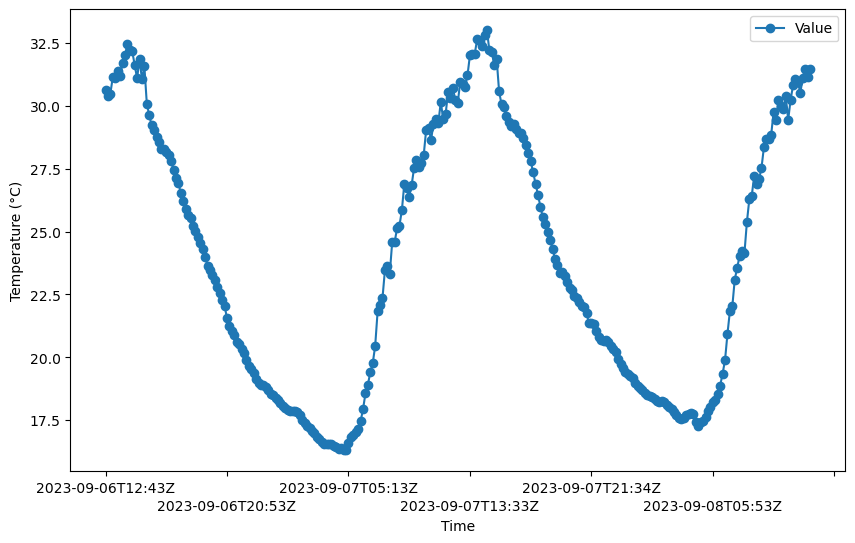

In [67]:
# Plot the data
ax = timeseries_temp.plot(x='Time', y='Value', figsize=(10,6), marker='o', linestyle='-')

# Add title and labels
ax.set_xlabel('Time')
ax.set_ylabel('Temperature (°C)')

# Rotate x-labels for better visibility
for i, label in enumerate(ax.get_xticklabels()):
    if i % 2 == 0:  # Check if it's an odd tick
        label.set_y(-0.04)

### Time series für länger